<a href="https://colab.research.google.com/github/AnthonyCrespo/keras_chexnet/blob/master/Tuberculosis_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sun Aug 28 16:34:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!git clone https://github.com/AnthonyCrespo/keras_chexnet.git

Cloning into 'keras_chexnet'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 88 (delta 41), reused 67 (delta 20), pack-reused 0
Unpacking objects: 100% (88/88), done.


In [4]:
%cd keras_chexnet
!git checkout tu
%cd ..

/content/keras_chexnet
Branch 'tu' set up to track remote branch 'tu' from 'origin'.
Switched to a new branch 'tu'
/content


In [6]:
%cp ./drive/Shareddrives/Universidad/images.zip ./keras_chexnet/data/
%cd ./keras_chexnet/data/
!unzip images.zip
%rm images.zip
%cd ..

/content/keras_chexnet/data
Archive:  images.zip
   creating: images/
 extracting: images/Normal-1.png     
 extracting: images/Normal-10.png    
  inflating: images/Normal-100.png   
 extracting: images/Normal-1000.png  
 extracting: images/Normal-1001.png  
 extracting: images/Normal-1002.png  
 extracting: images/Normal-1003.png  
  inflating: images/Normal-1004.png  
 extracting: images/Normal-1005.png  
 extracting: images/Normal-1006.png  
 extracting: images/Normal-1007.png  
  inflating: images/Normal-1008.png  
  inflating: images/Normal-1009.png  
  inflating: images/Normal-101.png   
 extracting: images/Normal-1010.png  
  inflating: images/Normal-1011.png  
  inflating: images/Normal-1012.png  
 extracting: images/Normal-1013.png  
  inflating: images/Normal-1014.png  
 extracting: images/Normal-1015.png  
 extracting: images/Normal-1016.png  
  inflating: images/Normal-1017.png  
 extracting: images/Normal-1018.png  
 extracting: images/Normal-1019.png  
 extracting: image

In [15]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/AnthonyCrespo/keras_chexnet
   575a7fc..5309fa4  tu         -> origin/tu
Updating 575a7fc..5309fa4
Fast-forward
 experiments/{best_weights.h5 => chexnet_weights.h5} | Bin
 1 file changed, 0 insertions(+), 0 deletions(-)
 rename experiments/{best_weights.h5 => chexnet_weights.h5} (100%)


In [57]:
!rm experiments/.training.lock

## Capa final

In [23]:
!python train.py

** use trained model weights **
backup config file to ./experiments/
** train_steps: 210 **
** validation_steps: 26 **
** compute class weights from training data **
** class_weights **
{0: 0.8366071428571429, 1: 0.16339285714285715}
** load model **
2022-08-28 17:20:27.461157: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
load model weights_path: ./experiments/chexnet_weights.h5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                            

## Completo

In [25]:
!python train.py

** use trained model weights **
backup config file to ./experiments/
** train_steps: 210 **
** validation_steps: 26 **
** compute class weights from training data **
** class_weights **
{0: 0.8366071428571429, 1: 0.16339285714285715}
** load model **
2022-08-28 17:55:35.904213: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
load model weights_path: ./experiments/best_final_layer_weights.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                     

In [29]:
!cp -r experiments/ ../drive/Shareddrives/Universidad/Tuberculosis/

In [50]:
import numpy as np
import os
from configparser import ConfigParser
from generator import AugmentedImageSequence
from models.keras import ModelFactory
from sklearn.metrics import roc_auc_score, confusion_matrix
from utility import get_sample_counts
from tensorflow.keras.optimizers import Adam

# parser config
config_file = "./config.ini"
cp = ConfigParser()
cp.read(config_file)

# default config
output_dir = cp["DEFAULT"].get("output_dir")
base_model_name = cp["DEFAULT"].get("base_model_name")
class_names = cp["DEFAULT"].get("class_names").split(",")
image_source_dir = cp["DEFAULT"].get("image_source_dir")

# train config
image_dimension = cp["TRAIN"].getint("image_dimension")

# test config
batch_size = cp["TEST"].getint("batch_size")
test_steps = cp["TEST"].get("test_steps")
use_best_weights = cp["TEST"].getboolean("use_best_weights")

# parse weights file path
output_weights_name = cp["TRAIN"].get("output_weights_name")
weights_path = os.path.join(output_dir, output_weights_name)
best_weights_path = os.path.join(output_dir, f"best_{output_weights_name}")

# get test sample count
test_counts, _ = get_sample_counts(output_dir, "dev", class_names)

# compute steps
if test_steps == "auto":
    test_steps = int(test_counts / batch_size)
else:
    try:
        test_steps = int(test_steps)
    except ValueError:
        raise ValueError(f"""
            test_steps: {test_steps} is invalid,
            please use 'auto' or integer.
            """)
print(f"** test_steps: {test_steps} **")

print("** load model **")
if use_best_weights:
    print("** use best weights **")
    #model_weights_path = best_weights_path
    model_weights_path = './experiments/best_weights.h5'
    model_weights_path = './experiments/best_final_layer_weights.h5'
    #model_weights_path = './experiments/best_complete_layer_weights.h5'
    
else:
    print("** use last weights **")
    model_weights_path = weights_path
model_factory = ModelFactory()
model = model_factory.get_model(
    class_names,
    model_name=base_model_name,
    use_base_weights=False,
    weights_path=model_weights_path,
    n_classes = 2)

print("** load test generator **")
test_sequence = AugmentedImageSequence(
    dataset_csv_file=os.path.join(output_dir, "test.csv"),
    class_names=class_names,
    source_image_dir=image_source_dir,
    batch_size=batch_size,
    target_size=(image_dimension, image_dimension),
    augmenter=None,
    steps=test_steps,
    shuffle_on_epoch_end=False,
)

print("** make prediction **")
y_hat = model.predict(test_sequence, verbose=1)
y = test_sequence.get_y_true()

test_log_path = os.path.join(output_dir, "test.log")
print(f"** write log to {test_log_path} **")
aurocs = []
with open(test_log_path, "w") as f:
    for i in range(len(class_names)):
        try:
            score = roc_auc_score(y[:, i], y_hat[:, i])
            aurocs.append(score)
        except ValueError:
            score = 0
        f.write(f"{class_names[i]}: {score}\n")
    mean_auroc = np.mean(aurocs)
    f.write("-------------------------\n")
    f.write(f"mean auroc: {mean_auroc}\n")
    print(f"mean auroc: {mean_auroc}")

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
score = model.evaluate(test_sequence, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


from keras import backend as K

def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return float(true_positives / (possible_positives + K.epsilon()))

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return float(true_negatives / (possible_negatives + K.epsilon()))

print(f"Sensitivity: ",recall(y.astype('float32'),y_hat.astype('float32')))
print(f"Specificity: ",specificity(y.astype('float32'),y_hat.astype('float32')))

matrix = confusion_matrix(np.argmax(y, axis=1), np.argmax(y_hat, axis=1))
print(matrix)

** test_steps: 13 **
** load model **
** use best weights **
load model weights_path: ./experiments/best_final_layer_weights.h5
** load test generator **
** make prediction **
13/13 [==============================] - 23s 2s/step
** write log to ./experiments/test.log **
mean auroc: 0.7516377427881853
13/13 [==============================] - 24s 2s/step - loss: 0.5297 - accuracy: 0.8149
Test loss: 0.5297304391860962
Test accuracy: 0.8149038553237915
Sensitivity:  0.8149038553237915
Specificity:  0.8149038553237915
[[339   0]
 [ 77   0]]


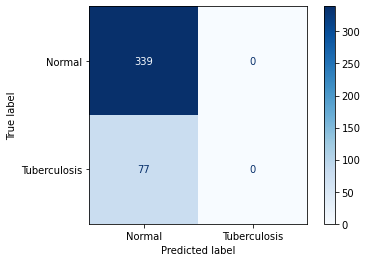

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


labels = ["Normal","Tuberculosis"]

cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(y_hat, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.savefig('line_plot.pdf') 
plt.show()

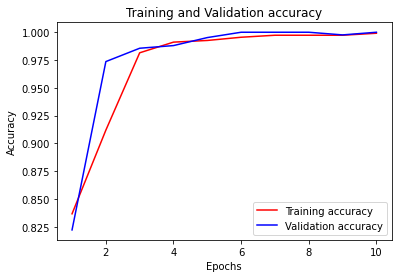

In [52]:
loss_train = [0.8366 , 0.9119, 0.9815, 0.9911, 0.9926, 0.9955, 0.9973 , 0.9973, 0.9973, 0.9991]
loss_val = [0.8221 , 0.9736, 0.9856, 0.9880, 0.9952, 1.0000 , 1.0000 , 1.0000 , 0.9976, 1.0000]
epochs = range(1,11)
plt.plot(epochs, loss_train, 'r', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

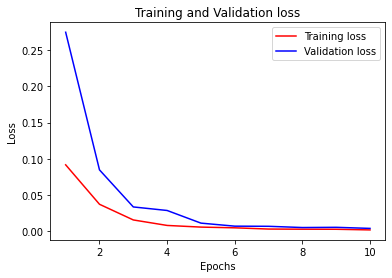

In [55]:
loss_train = [0.0915 , 0.0369, 0.0152, 0.0076, 0.0053 , 0.0043 ,0.0026,  0.0024, 0.0023, 0.0014]
loss_val = [0.2750 , 0.0845, 0.0332 , 0.0283 , 0.0108,  0.0066, 0.0064 , 0.0047 ,  0.0050, 0.0035]
epochs = range(1,11)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Modelo completo sin entrenamiento de la capa final

In [58]:
!python train.py

** use trained model weights **
backup config file to ./experiments/
** train_steps: 210 **
** validation_steps: 26 **
** compute class weights from training data **
** class_weights **
{0: 0.8366071428571429, 1: 0.16339285714285715}
** load model **
2022-08-28 19:37:30.835791: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
load model weights_path: ./experiments/chexnet_weights.h5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                            

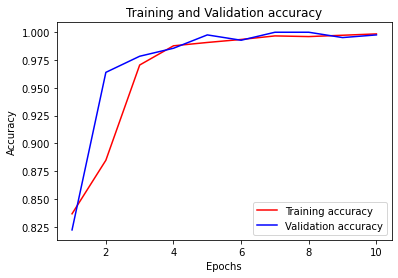

In [66]:
loss_train = [0.8366 , 0.8848, 0.9705, 0.9878, 0.9908, 0.9935, 0.9967,0.9961 , 0.9973, 0.9985]
loss_val = [0.8221 , 0.9639, 0.9784, 0.9856, 0.9976, 0.9928, 1, 1, 0.9952, 0.9976]
epochs = range(1,11)
plt.plot(epochs, loss_train, 'r', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

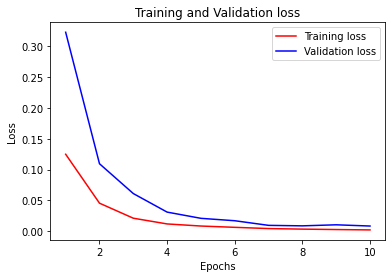

In [65]:
loss_train = [0.1248, 0.0454, 0.0210, 0.0117, 0.0083, 0.0062, 0.0042, 0.0033, 0.0026, 0.0020]
loss_val = [0.3228, 0.1094, 0.0610, 0.0309, 0.0208, 0.0169, 0.0094, 0.0086, 0.0103, 0.0083]
epochs = range(1,11)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Balanced 50-50

In [ ]:
!python train.py

** use trained model weights **
backup config file to ./experiments/
** train_steps: 210 **
** validation_steps: 26 **
** compute class weights from training data **
** class_weights **
{0: 0.8366071428571429, 1: 0.16339285714285715}
** load model **
2022-08-28 05:22:13.665993: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
load model weights_path: ./experiments/best_weights.h5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                               

# Mejor no borrar

In [ ]:
!python train.py

** use trained model weights **
backup config file to ./experiments/
** train_steps: 210 **
** validation_steps: 26 **
** compute class weights from training data **
** class_weights **
{0: 0.8366071428571429, 1: 0.16339285714285715}
** load model **
2022-08-28 05:46:38.191816: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
load model weights_path: ./experiments/best_weights.h5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                               

In [ ]:
!python test.py

** test_steps: 13 **
** load model **
** use best weights **
2022-08-28 06:40:22.895891: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
load model weights_path: ./experiments/best_weights.h5
** load test generator **
** make prediction **
13/13 [==============================] - 25s 1s/step
** write log to ./experiments/test.log **
mean auroc: 0.9999233804543539
13/13 [==============================] - 27s 2s/step - loss: 0.0399 - accuracy: 0.9880
Test loss: 0.039880577474832535
Test accuracy: 0.9879807829856873


In [ ]:
!python train.py

** use trained model weights **
backup config file to ./experiments/
** train_steps: 210 **
** validation_steps: 26 **
** compute class weights from training data **
** class_weights **
{0: 0.8366071428571429, 1: 0.16339285714285715}
** load model **
2022-08-28 06:56:07.259635: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
load model weights_path: ./experiments/best_weights.h5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                               

In [ ]:
import numpy as np
import os
from configparser import ConfigParser
from generator import AugmentedImageSequence
from models.keras import ModelFactory
from sklearn.metrics import roc_auc_score, confusion_matrix
from utility import get_sample_counts
from tensorflow.keras.optimizers import Adam

# parser config
config_file = "./config.ini"
cp = ConfigParser()
cp.read(config_file)

# default config
output_dir = cp["DEFAULT"].get("output_dir")
base_model_name = cp["DEFAULT"].get("base_model_name")
class_names = cp["DEFAULT"].get("class_names").split(",")
image_source_dir = cp["DEFAULT"].get("image_source_dir")

# train config
image_dimension = cp["TRAIN"].getint("image_dimension")

# test config
batch_size = cp["TEST"].getint("batch_size")
test_steps = cp["TEST"].get("test_steps")
use_best_weights = cp["TEST"].getboolean("use_best_weights")

# parse weights file path
output_weights_name = cp["TRAIN"].get("output_weights_name")
weights_path = os.path.join(output_dir, output_weights_name)
best_weights_path = os.path.join(output_dir, f"best_{output_weights_name}")

# get test sample count
test_counts, _ = get_sample_counts(output_dir, "dev", class_names)

# compute steps
if test_steps == "auto":
    test_steps = int(test_counts / batch_size)
else:
    try:
        test_steps = int(test_steps)
    except ValueError:
        raise ValueError(f"""
            test_steps: {test_steps} is invalid,
            please use 'auto' or integer.
            """)
print(f"** test_steps: {test_steps} **")

print("** load model **")
if use_best_weights:
    print("** use best weights **")
    #model_weights_path = best_weights_path
    model_weights_path = './experiments/best_weights.h5'
else:
    print("** use last weights **")
    model_weights_path = weights_path
model_factory = ModelFactory()
model = model_factory.get_model(
    class_names,
    model_name=base_model_name,
    use_base_weights=False,
    weights_path=model_weights_path)

print("** load test generator **")
test_sequence = AugmentedImageSequence(
    dataset_csv_file=os.path.join(output_dir, "dev.csv"),
    class_names=class_names,
    source_image_dir=image_source_dir,
    batch_size=batch_size,
    target_size=(image_dimension, image_dimension),
    augmenter=None,
    steps=test_steps,
    shuffle_on_epoch_end=False,
)

print("** make prediction **")
y_hat = model.predict(test_sequence, verbose=1)
y = test_sequence.get_y_true()

test_log_path = os.path.join(output_dir, "test.log")
print(f"** write log to {test_log_path} **")
aurocs = []
with open(test_log_path, "w") as f:
    for i in range(len(class_names)):
        try:
            score = roc_auc_score(y[:, i], y_hat[:, i])
            aurocs.append(score)
        except ValueError:
            score = 0
        f.write(f"{class_names[i]}: {score}\n")
    mean_auroc = np.mean(aurocs)
    f.write("-------------------------\n")
    f.write(f"mean auroc: {mean_auroc}\n")
    print(f"mean auroc: {mean_auroc}")

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
score = model.evaluate(test_sequence, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


from keras import backend as K

def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return float(true_positives / (possible_positives + K.epsilon()))

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return float(true_negatives / (possible_negatives + K.epsilon()))

print(f"Sensitivity: ",recall(y.astype('float32'),y_hat.astype('float32')))
print(f"Specificity: ",specificity(y.astype('float32'),y_hat.astype('float32')))

matrix = confusion_matrix(np.argmax(y, axis=1), np.argmax(y_hat, axis=1))
print(matrix)

** test_steps: 13 **
** load model **
** use best weights **
load model weights_path: ./experiments/best_weights.h5
** load test generator **
** make prediction **
13/13 [==============================] - 24s 2s/step
** write log to ./experiments/test.log **
mean auroc: 1.0
13/13 [==============================] - 27s 2s/step - loss: 0.0174 - accuracy: 0.9952
Test loss: 0.01737704500555992
Test accuracy: 0.995192289352417
Sensitivity:  0.995192289352417
Specificity:  0.995192289352417
[[342   0]
 [  2  72]]


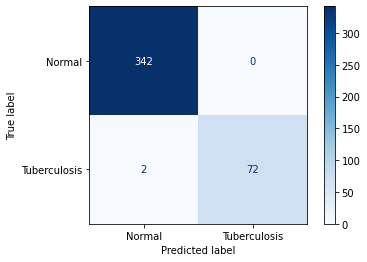

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


labels = ["Normal","Tuberculosis"]

cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(y_hat, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.savefig('line_plot.pdf') 
plt.show()



In [ ]:
!python test.py

** test_steps: 47 **
** load model **
** use best weights **
2022-08-28 03:15:07.303148: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
load model weights_path: ./experiments/best_weights.h5
** load test generator **
** make prediction **
test.py:78: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_hat = model.predict_generator(test_sequence, verbose=1)
47/47 [==============================] - 258s 5s/step
** write log to ./experiments/test.log **
mean auroc: 0.7855655858251656
